In [20]:
import numpy as np
import requests, gzip, hashlib, os
def fetch(url):
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape(-1, 784)
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1, 784)
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

#normalize
std_train = np.std(X_train, axis=0)
normal_train_cache = np.ones(X_train.shape[1]) * std_train
normal_train_cache[normal_train_cache < 1] = 1
normal_train = np.ones(X_train.shape) * std_train
normal_train[normal_train < 1] = 1
X_train = X_train / normal_train * std_train
std_test = np.std(X_test, axis=0)
normal_test = np.ones(X_test.shape) * std_test
normal_test[normal_test < 1] = 1
X_test = X_test / normal_test * std_test
#center
train_mean, test_mean = X_train.mean(), X_test.mean()
X_train, X_test = (X_train - train_mean, X_test - test_mean)

In [6]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

def forward_backward_dropout(x, y):
    #forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    dropout = np.ones(x_relu.shape) * np.random.randint(0,2, size=(x_relu.shape[1]))
    x_dropout = x_relu * dropout
    x_l2 = x_dropout.dot(l2)
    
    #backward pass
    out = np.zeros((len(y), 10))
    out[range(out.shape[0]), y] = 1
    #softmax loss
    loss = (np.exp(x_l2)/np.exp(x_l2).sum(axis=1).reshape(-1,1)-out)/len(y)
    d_l2 = x_dropout.T.dot(loss)
    d_relu = (x_l1 > 0) * dropout
    d_l1 = x.T.dot(d_relu * loss.dot(l2.T))
    
    return d_l1, d_l2


def forward_backward(x, y):
    #forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    
    #backward pass
    out = np.zeros((len(y), 10))
    out[range(out.shape[0]), y] = 1
    #softmax loss
    loss = (np.exp(x_l2)/np.exp(x_l2).sum(axis=1).reshape(-1,1)-out)/len(y)
    d_l2 = x_relu.T.dot(loss)
    d_l1 = x.T.dot((x_relu > 0) * loss.dot(l2.T))
    
    return d_l1, d_l2

def forward_backward_lrelu(x, y):
    #forward pass
    x_l1 = x.dot(l1)
    x_lrelu = np.maximum(x_l1, x_l1 * .1)
    x_l2 = x_lrelu.dot(l2)
    
    #backward pass
    out = np.zeros((len(y), 10))
    out[range(out.shape[0]), y] = 1
    #softmax loss
    loss = (np.exp(x_l2)/np.exp(x_l2).sum(axis=1).reshape(-1,1)-out)/len(y)
    d_l2 = x_lrelu.T.dot(loss)
    d_l1 = x.T.dot((x_lrelu / x_l1) * loss.dot(l2.T))
    
    return d_l1, d_l2
def forward_backward_lrelu_dropout(x, y):
    #forward pass
    x_l1 = x.dot(l1)
    x_lrelu = np.maximum(x_l1, x_l1 * .1)
    dropout = np.ones(x_lrelu.shape) * np.random.randint(0,2, size=(x_lrelu.shape[1]))
    x_dropout = x_lrelu * dropout
    x_l2 = x_lrelu.dot(l2)
    
    #backward pass
    out = np.zeros((len(y), 10))
    out[range(out.shape[0]), y] = 1
    #softmax loss
    loss = (np.exp(x_l2)/np.exp(x_l2).sum(axis=1).reshape(-1,1)-out)/len(y)
    d_l2 = x_dropout.T.dot(loss)
    d_l1 = x.T.dot((x_lrelu / x_l1) * loss.dot(l2.T))
    
    return d_l1, d_l2

In [7]:
np.random.seed(4269)
lr = .0018
l1 = np.random.uniform(-1., 1., size=(784, 128)) / np.sqrt(784*128)
l2 = np.random.uniform(-1., 1., size=(128, 10)) / np.sqrt(128*10)
BS = 64

#training
for i in range(1000):
    
    #get batch
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = X_train[samp]
    Y = Y_train[samp]
    
    #forward and backward pass
    d_l1, d_l2 = forward_backward(X, Y)
    
    #sgd
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2

In [8]:
#eval
output = forward(X_test)
predictions = np.argmax(output, axis=1)
(Y_test == predictions).mean()
#relu always wins, fuckin op

0.9654

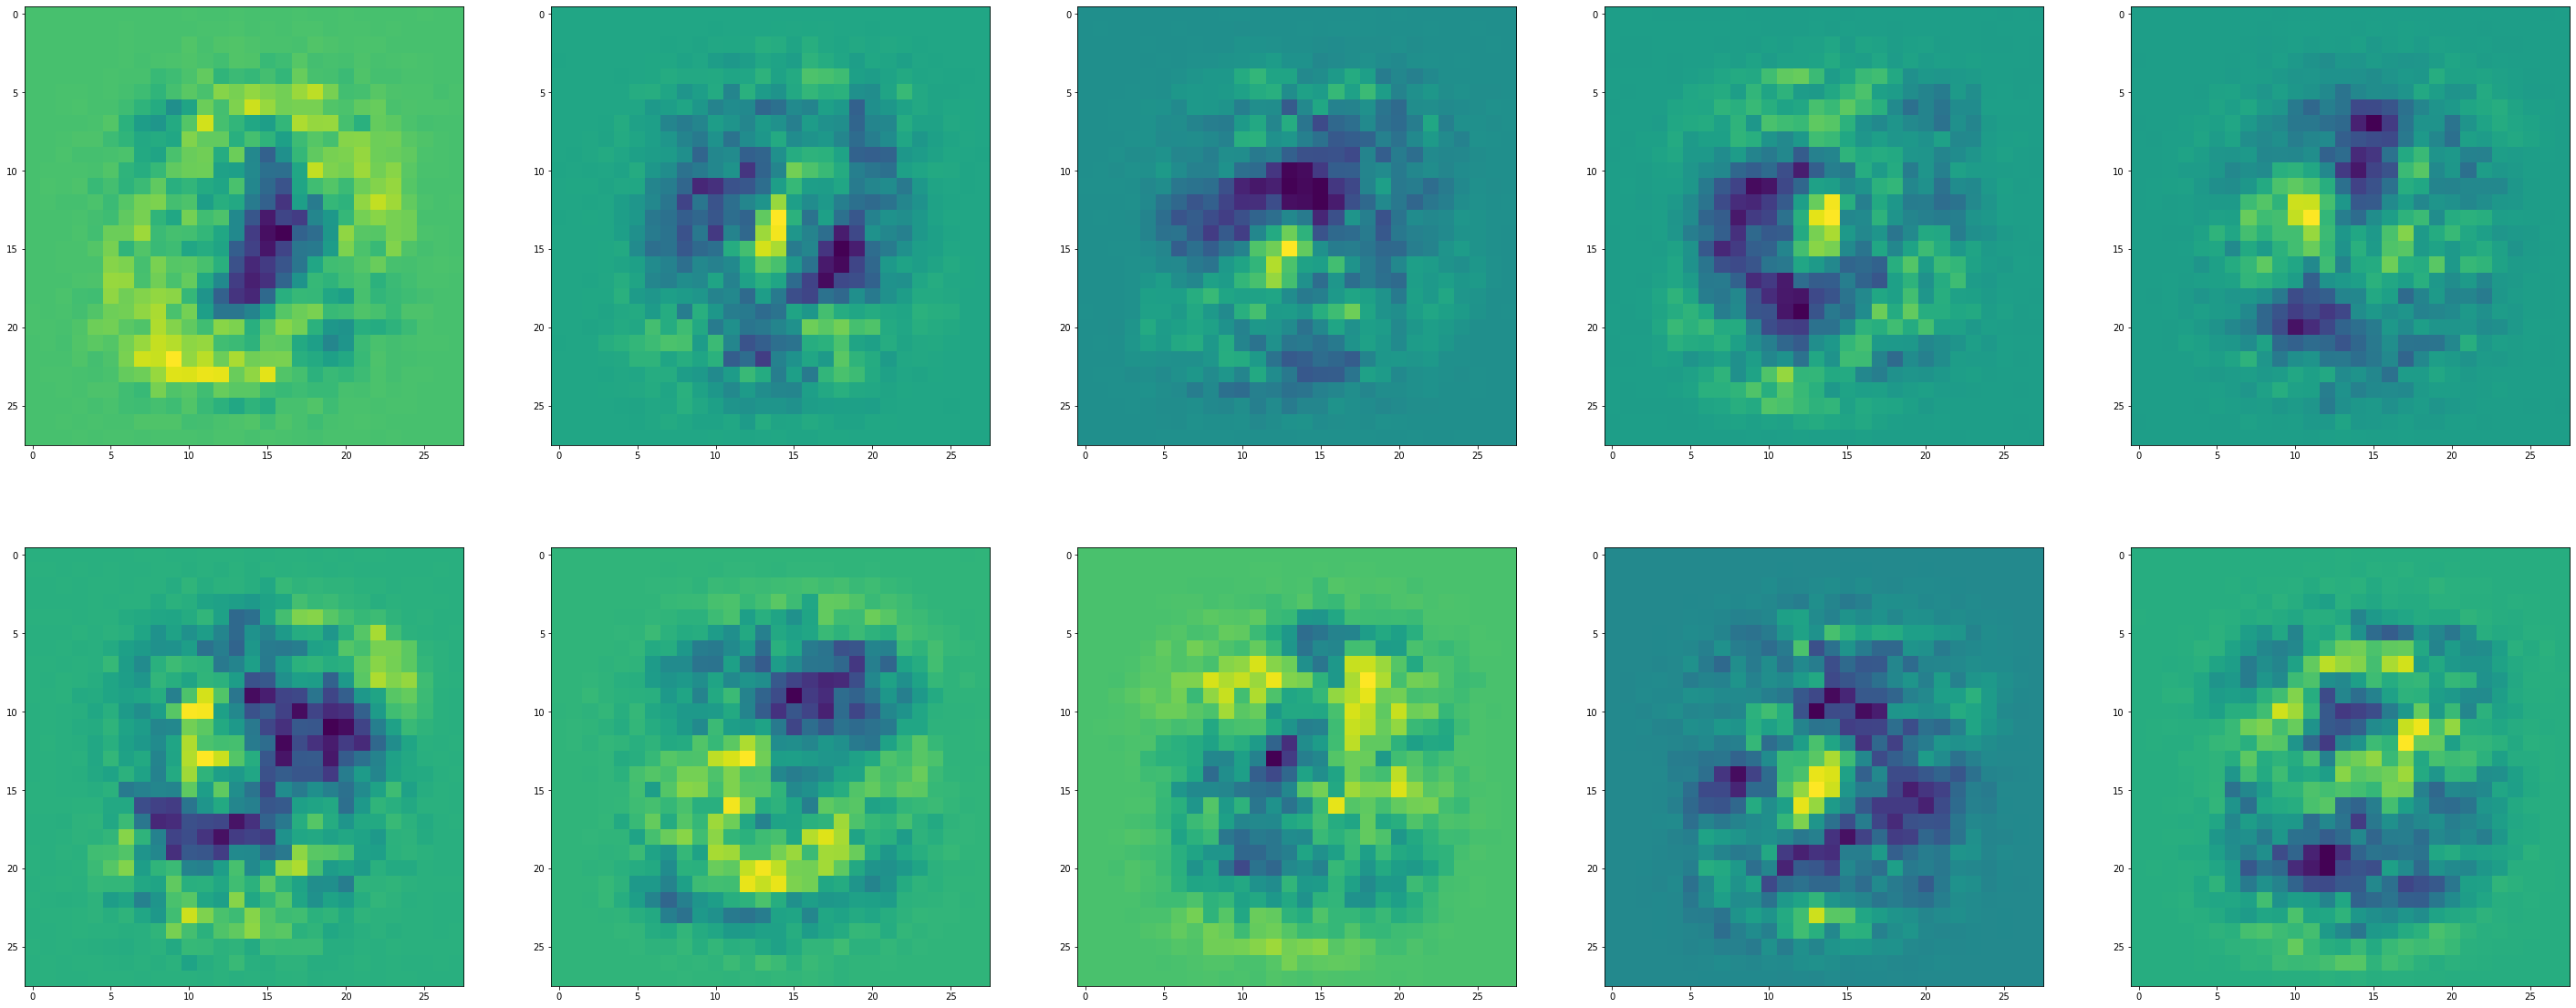

In [33]:
#make the "characteristic" image for each class
import matplotlib.pyplot as plt
images = []
for i in range(10):
    arr = np.zeros(10)
    arr[i] = 1
    x = l2.dot(arr)
    x = np.maximum(x, 0)
    x = l1.dot(x)
    x = x * normal_train_cache + train_mean
    images.append(x)
f, axarr = plt.subplots(2,5, figsize=(50,20))
for i in range(len(images)):
    axarr[i//5, i%5].imshow(images[i].reshape(28,28))